<h1 style="text-align: center">Solving the N-Queens Problem with Genetic Programming</h1>

<hr style="border-top: 2px solid #444">

## Development Environment

### Python Dependencies

In [1]:
!pip install -r pipenv-requirements.txt
!pipenv install

### Python Imports

In [2]:
import sys
import random
import deap
import numpy
import pandas
from typing import List, Tuple
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as pyplot
from IPython.display import display

print(f"Python version: {sys.version}")
print(f"DEAP version: {deap.__version__}")

Python version: 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]
DEAP version: 1.3


### Deterministic

In [3]:
random.seed(42)

### Configure Pandas

In [4]:
pandas.set_option('display.max_rows', None)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.width', None)
pandas.set_option('display.max_colwidth', None)

### Helper Methods

#### Visualization Plotter

In [5]:
def plot_generations(generation: List[int], average: List[float], minimum: List[int]):
    pyplot.figure(figsize=(12, 6))
    pyplot.grid(True)
    pyplot.plot(generation, average, label="average")
    pyplot.plot(generation, minimum, label="minimum")
    pyplot.xlabel("Generation")
    pyplot.ylabel("Fitness")
    pyplot.ylim(-1)
    pyplot.legend(loc="upper right")
    pyplot.show()

<hr style="border-top: 2px solid #444">

## Part I: Position-index Board Encoding
- For an 8x8 board, there are (8^2)^8 possible states: 281,474,976,710,656
- For an 16x16 board, there are (16^2)^16 possible states: 340,282,366,920,938,463,463,374,607,431,768,211,456

### Register DEAP Toolbox

In [6]:
creator.create("fitness_min_p", base.Fitness, weights=(-1.0,))
creator.create("individual_p", list, fitness=creator.fitness_min_p)

# register individuals and population generators
toolbox_p = base.Toolbox()
toolbox_p.register("range_8", random.randint, 0, 8 ** 2 - 1)
toolbox_p.register("range_16", random.randint, 0, 16 ** 2 - 1)
toolbox_p.register("individual_8", tools.initRepeat, creator.individual_p, toolbox_p.range_8, n=8)
toolbox_p.register("individual_16", tools.initRepeat, creator.individual_p, toolbox_p.range_16, n=16)
toolbox_p.register("population_8", tools.initRepeat, list, toolbox_p.individual_8)
toolbox_p.register("population_16", tools.initRepeat, list, toolbox_p.individual_16)

### Rendering Positional Board

In [7]:
def show_positional_grid(individual: List[int], dimensions: Tuple[int, int] = (8, 8)):
    rows, columns = dimensions

    # construct board in pandas
    board = pandas.DataFrame("", index = range(rows), columns = range(columns))

    # draw conflicts, if possible
    for x in range(len(individual)):
        x_row, x_column = individual[x] // rows, individual[x] % columns
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // rows, individual[y] % columns
            diff_row, diff_column = y_row - x_row, y_column - x_column
            if x_row == y_row or x_column == y_column or abs(diff_row) == abs(diff_column):
                # draw a line of the conflict
                for i in range(diff_row):
                    board[x_column + i * numpy.sign(diff_column)][x_row + i * numpy.sign(diff_row)] = "🟥"

    # map board
    for queen in individual:
        board[queen % columns][queen // rows] = "👑"

    # display render
    display(board)

### Example 8x8 Individual

In [8]:
example_individual_p = toolbox_p.population_8(n = 1)[0]
print(f"Positions: {example_individual_p}")
print(f"Duplicate positions: {len(example_individual_p) - len(set(example_individual_p))}")
show_positional_grid(example_individual_p)

Positions: [14, 3, 35, 31, 28, 17, 13, 11]
Duplicate positions: 0


,0,1,2,3,4,5,6,7
0,,,,👑,,,,
1,,,🟥,👑,,👑,👑,
2,,👑,,🟥,,🟥,,
3,,,,🟥,👑,,,👑
4,,,,👑,,,,
5,,,,,,,,
6,,,,,,,,
7,,,,,,,,


#### Fitness Function
Time complexity: `O(|queens|^2)`

In [9]:
def evaluate_position_indexed_fitness(individual: List[int], dimensions: Tuple[int, int] = (8, 8)) -> float:
    rows, columns = dimensions

    fitness: float = 0

    # count all pairs of conflicts
    for x in range(len(individual)):
        x_row, x_column = individual[x] // rows, individual[x] % columns
        for y in range(x + 1, len(individual)):
            y_row, y_column = individual[y] // rows, individual[y] % columns
            if x_row == y_row or x_column == y_column or abs(x_row - y_row) == abs(x_column - y_column):
                fitness += 1

    # penalize duplicate entries significantly
    fitness += 15 * (len(individual) - len(set(individual)))

    return fitness

### Evolutionary Algorithm on a 8x8 Board

#### Evolutionary Computation

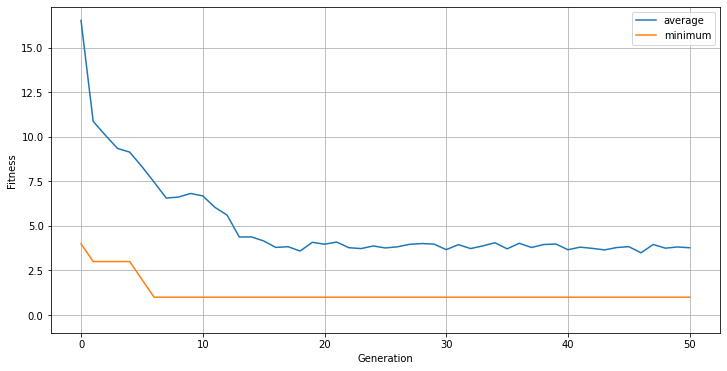

In [10]:
# register possible genetic mutations
toolbox_p.register("mate", tools.cxTwoPoint)
toolbox_p.register("mutate", tools.mutUniformInt, low=0, up=8**2 - 1, indpb=0.2)
toolbox_p.register("select", tools.selTournament, tournsize=8)

# register fitness evaluation function
toolbox_p.register("evaluate", lambda individual: (evaluate_position_indexed_fitness(individual),))

# statistics logging
stats_p8 = tools.Statistics(key=lambda individual: individual.fitness.values)
stats_p8.register("min", numpy.min)
stats_p8.register("max", numpy.max)
stats_p8.register("avg", numpy.mean)

# log fittest individual with hall of fame record
hall_of_fame_p8 = tools.HallOfFame(maxsize=1)

# run genetic algorithm
_, log_p8 = algorithms.eaSimple(
    toolbox_p.population_8(n=1000), toolbox_p,
    cxpb=0.5, mutpb=0.5, ngen=50,
    stats=stats_p8, halloffame=hall_of_fame_p8, verbose=False,
)
plot_generations(*log_p8.select("gen", "avg", "min"))

#### Fittest Individual

In [11]:
print(f"Positions: {hall_of_fame_p8[0]}")
print(f"Fitness: {abs(hall_of_fame_p8[0].fitness.wvalues[0])}")
show_positional_grid(hall_of_fame_p8[0])

Positions: [51, 12, 50, 17, 61, 46, 31, 0]
Fitness: 1.0


,0,1,2,3,4,5,6,7
0,👑,,,,,,,
1,,,,,👑,,,
2,,👑,,,,,,
3,,,,,,,,👑
4,,,,,,,,
5,,,,,,,👑,
6,,,👑,👑,,,,
7,,,,,,👑,,


### Evolutionary Algorithm on a 16x16 Board

#### Evolutionary Computation

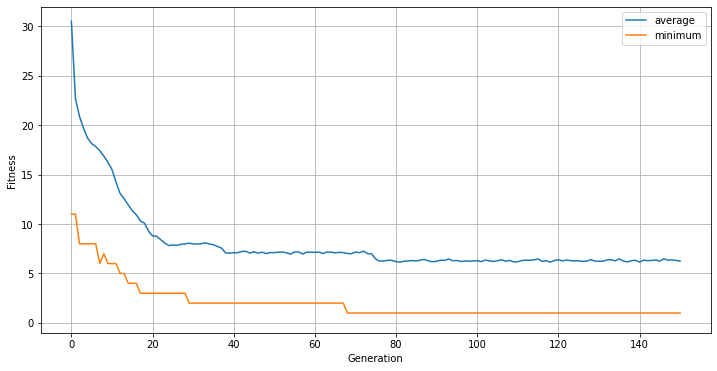

In [12]:
# register possible genetic mutations
toolbox_p.register("mate", tools.cxTwoPoint)
toolbox_p.register("mutate", tools.mutUniformInt, low=0, up=16**2 - 1, indpb=0.2)
toolbox_p.register("select", tools.selTournament, tournsize=8)

# register fitness evaluation function
toolbox_p.register("evaluate", lambda individual: (evaluate_position_indexed_fitness(individual, dimensions=(16, 16)),))

# statistics logging
stats_p16 = tools.Statistics(key=lambda individual: individual.fitness.values)
stats_p16.register("min", numpy.min)
stats_p16.register("max", numpy.max)
stats_p16.register("avg", numpy.mean)

# log fittest individual with hall of fame record
hall_of_fame_p16 = tools.HallOfFame(maxsize=1)

# run genetic algorithm
_, log_p16 = algorithms.eaSimple(
    toolbox_p.population_16(n=10000), toolbox_p,
    cxpb=0.5, mutpb=0.5, ngen=150,
    stats=stats_p16, halloffame=hall_of_fame_p16, verbose=False,
)
plot_generations(*log_p16.select("gen", "avg", "min"))

#### Fittest Individual

In [13]:
print(f"Positions: {hall_of_fame_p16[0]}")
print(f"Fitness: {abs(hall_of_fame_p16[0].fitness.wvalues[0])}")
show_positional_grid(hall_of_fame_p16[0], dimensions=(16, 16))

Positions: [134, 212, 201, 103, 237, 24, 91, 37, 174, 250, 176, 12, 2, 79, 145, 51]
Fitness: 1.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,👑,,,,,,,,,,👑,,,
1,,,,,,,,,👑,,,,,,,
2,,,,,,👑,,,,,,,,,,
3,,,,👑,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,👑
5,,,,,,,,,,,,👑,,,,
6,,,,,,,,👑,,,,,,,,
7,,,,,,,,,,,,,,,,
8,,,,,,,👑,,,,,,,,,
9,,👑,,,,,,,,,,,,,,


### Notes
- Despite higher population and generation counts, this board representation suffers for larger board sizes

<hr style="border-top: 2px solid #444">

## II. Row-index Board Encoding

- For an 8x8 board, there are 8^8 possible states: 16,777,216
- For an 16x16 board, there are 16^16 possible states: 18,446,744,073,709,551,616

### Register DEAP Toolbox

In [14]:
creator.create("fitness_min_r", base.Fitness, weights=(-1.0,))
creator.create("individual_r", list, fitness=creator.fitness_min_p)

# register individuals and population generators
toolbox_r = base.Toolbox()
toolbox_r.register("range_8", random.randint, 0, 8 - 1)
toolbox_r.register("range_16", random.randint, 0, 16 - 1)
toolbox_r.register("range_32", random.randint, 0, 32 - 1)
toolbox_r.register("individual_8", tools.initRepeat, creator.individual_p, toolbox_r.range_8, n=8)
toolbox_r.register("individual_16", tools.initRepeat, creator.individual_p, toolbox_r.range_16, n=16)
toolbox_r.register("individual_32", tools.initRepeat, creator.individual_p, toolbox_r.range_16, n=32)
toolbox_r.register("population_8", tools.initRepeat, list, toolbox_r.individual_8)
toolbox_r.register("population_16", tools.initRepeat, list, toolbox_r.individual_16)
toolbox_r.register("population_32", tools.initRepeat, list, toolbox_r.individual_32)

### Rendering Positional Board

In [15]:
def show_row_grid(individual: List[int]):
    size = len(individual)
    show_positional_grid(
        [size * i + individual[i] for i in range(size)],
        dimensions=(size, size)
    )

### Example 8x8 Individual

In [16]:
example_individual_r = toolbox_r.population_8(n = 1)[0]
print(f"Positions: {example_individual_r}")
show_row_grid(example_individual_r)

Positions: [2, 7, 0, 4, 1, 7, 0, 2]


,0,1,2,3,4,5,6,7
0,,,👑,,,,,
1,,🟥,🟥,🟥,,,,👑
2,👑,,🟥,,🟥,,,🟥
3,🟥,,🟥,,👑,🟥,,🟥
4,🟥,👑,🟥,,,,🟥,🟥
5,🟥,,🟥,,,,,👑
6,👑,,🟥,,,,,
7,,,👑,,,,,


#### Fitness Function
Time complexity: `O(|queens|^2)`

In [17]:
def evaluate_row_indexed_fitness(individual: List[int]) -> float:
    size = len(individual)
    return evaluate_position_indexed_fitness(
        [size * i + individual[i] for i in range(size)],
        dimensions=(size, size)
    )

### Evolutionary Algorithm on a 8x8 Board

#### Evolutionary Computation

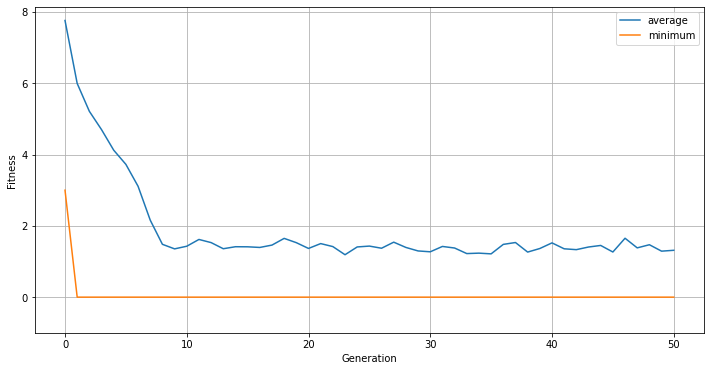

In [18]:
# register possible genetic mutations
toolbox_r.register("mate", tools.cxTwoPoint)
toolbox_r.register("mutate", tools.mutUniformInt, low=0, up=8 - 1, indpb=0.2)
toolbox_r.register("select", tools.selTournament, tournsize=8)

# register fitness evaluation function
toolbox_r.register("evaluate", lambda individual: (evaluate_row_indexed_fitness(individual),))

# statistics logging
stats_r8 = tools.Statistics(key=lambda individual: individual.fitness.values)
stats_r8.register("min", numpy.min)
stats_r8.register("max", numpy.max)
stats_r8.register("avg", numpy.mean)

# log fittest individual with hall of fame record
hall_of_fame_r8 = tools.HallOfFame(maxsize=1)

# run genetic algorithm
_, log_r8 = algorithms.eaSimple(
    toolbox_r.population_8(n=500), toolbox_r,
    cxpb=0.5, mutpb=0.5, ngen=50,
    stats=stats_r8, halloffame=hall_of_fame_r8, verbose=False,
)
plot_generations(*log_r8.select("gen", "avg", "min"))

#### Fittest Individual

In [19]:
print(f"Positions: {hall_of_fame_r8[0]}")
print(f"Fitness: {abs(hall_of_fame_r8[0].fitness.wvalues[0])}")
show_row_grid(hall_of_fame_r8[0])

Positions: [5, 3, 1, 7, 4, 6, 0, 2]
Fitness: 0.0


,0,1,2,3,4,5,6,7
0,,,,,,👑,,
1,,,,👑,,,,
2,,👑,,,,,,
3,,,,,,,,👑
4,,,,,👑,,,
5,,,,,,,👑,
6,👑,,,,,,,
7,,,👑,,,,,


### Evolutionary Algorithm on a 16x16 Board

#### Evolutionary Computation

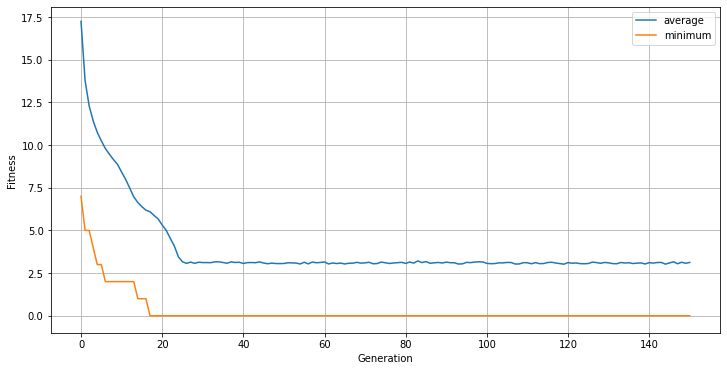

In [20]:
# register possible genetic mutations
toolbox_r.register("mate", tools.cxTwoPoint)
toolbox_r.register("mutate", tools.mutUniformInt, low=0, up=16 - 1, indpb=0.2)
toolbox_r.register("select", tools.selTournament, tournsize=8)

# register fitness evaluation function
toolbox_r.register("evaluate", lambda individual: (evaluate_row_indexed_fitness(individual),))

# statistics logging
stats_r16 = tools.Statistics(key=lambda individual: individual.fitness.values)
stats_r16.register("min", numpy.min)
stats_r16.register("max", numpy.max)
stats_r16.register("avg", numpy.mean)

# log fittest individual with hall of fame record
hall_of_fame_r16 = tools.HallOfFame(maxsize=1)

# run genetic algorithm
_, log_r16 = algorithms.eaSimple(
    toolbox_r.population_16(n=10000), toolbox_r,
    cxpb=0.5, mutpb=0.5, ngen=150,
    stats=stats_r16, halloffame=hall_of_fame_r16, verbose=False,
)
plot_generations(*log_r16.select("gen", "avg", "min"))

#### Fittest Individual

In [21]:
print(f"Positions: {hall_of_fame_r16[0]}")
print(f"Fitness: {abs(hall_of_fame_r16[0].fitness.wvalues[0])}")
show_row_grid(hall_of_fame_r16[0])

Positions: [12, 14, 2, 0, 7, 4, 8, 13, 15, 1, 11, 6, 10, 3, 5, 9]
Fitness: 0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,,,,,,,,,,,,,👑,,,
1,,,,,,,,,,,,,,,👑,
2,,,👑,,,,,,,,,,,,,
3,👑,,,,,,,,,,,,,,,
4,,,,,,,,👑,,,,,,,,
5,,,,,👑,,,,,,,,,,,
6,,,,,,,,,👑,,,,,,,
7,,,,,,,,,,,,,,👑,,
8,,,,,,,,,,,,,,,,👑
9,,👑,,,,,,,,,,,,,,


### Evolutionary Algorithm on a 32x32 Board

#### Evolutionary Computation

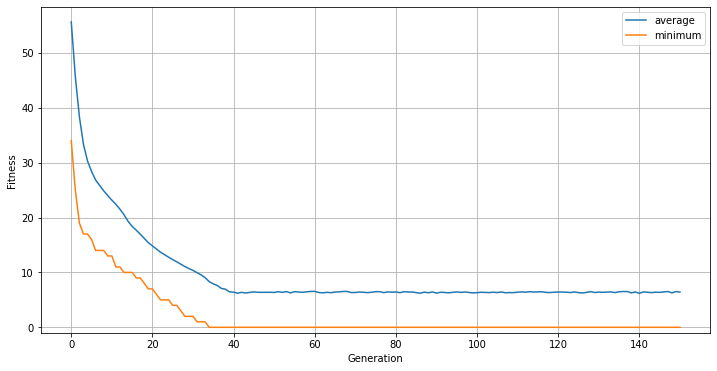

In [22]:
# register possible genetic mutations
toolbox_r.register("mate", tools.cxTwoPoint)
toolbox_r.register("mutate", tools.mutUniformInt, low=0, up=32 - 1, indpb=0.2)
toolbox_r.register("select", tools.selTournament, tournsize=8)

# register fitness evaluation function
toolbox_r.register("evaluate", lambda individual: (evaluate_row_indexed_fitness(individual),))

# statistics logging
stats_r32 = tools.Statistics(key=lambda individual: individual.fitness.values)
stats_r32.register("min", numpy.min)
stats_r32.register("max", numpy.max)
stats_r32.register("avg", numpy.mean)

# log fittest individual with hall of fame record
hall_of_fame_r32 = tools.HallOfFame(maxsize=1)

# run genetic algorithm
_, log_r32 = algorithms.eaSimple(
    toolbox_r.population_32(n=10000), toolbox_r,
    cxpb=0.5, mutpb=0.5, ngen=150,
    stats=stats_r32, halloffame=hall_of_fame_r32, verbose=False,
)
plot_generations(*log_r32.select("gen", "avg", "min"))

#### Fittest Individual

In [23]:
print(f"Positions: {hall_of_fame_r32[0]}")
print(f"Fitness: {abs(hall_of_fame_r32[0].fitness.wvalues[0])}")
show_row_grid(hall_of_fame_r32[0])

Positions: [16, 4, 6, 15, 13, 25, 30, 21, 5, 2, 28, 1, 22, 19, 12, 9, 27, 24, 31, 3, 20, 0, 7, 10, 29, 14, 18, 8, 23, 17, 26, 11]
Fitness: 0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,
1,,,,,👑,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,,,,,,,👑,,,,,,,,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,👑,,,,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,,,,,,,,,,,,👑,,,,,,
6,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,👑,
7,,,,,,,,,,,,,,,,,,,,,,👑,,,,,,,,,,
8,,,,,,👑,,,,,,,,,,,,,,,,,,,,,,,,,,
9,,,👑,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


<hr style="border-top: 2px solid #444">

## III. Conclusion